In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm

from korgorusz.optimizers import SGDOptimizer
from korgorusz.layers import *
from korgorusz.utils import *

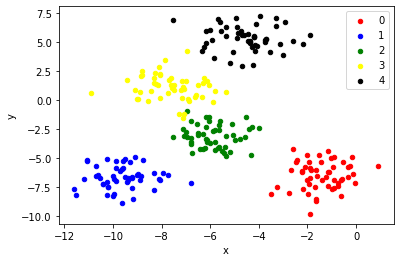

In [2]:
classes = 5
x, y = make_blobs(n_samples=256, centers=classes, n_features=2)
df = pd.DataFrame(dict(x=x[:,0], y=x[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green',3:'yellow',4:'black'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()
y=one_hot(y,classes)
x,y = shuffle(x,y)
test_size=25
x,y,x_test,y_test=x[:-test_size],y[:-test_size],x[:test_size],y[:test_size]

In [3]:
x.shape,y.shape,x_test.shape,y_test.shape

((231, 2), (231, 5), (25, 2), (25, 5))

In [4]:
class ModelLearn(Model):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers

    def forward(self, X):
        for l in self.layers:
            X, b = l.forward(X)
            self.add_derivative(b)
        return X

In [5]:
lr = 0.01
bs = 16
epoch = 20

In [6]:
ml = ModelLearn([
    Linear(2, 16),
    ReLU(),
    Linear(16, 16),
    ReLU(),
    Linear(16, 5),
    Softmax()])
optim = SGDOptimizer(lr=lr)
loss_f = mse
losses = []

for e in tqdm(range(epoch)):
    running_loss=0.0
    x_num =0.0
    for x_b,y_b in minibatch(x,y,bs):
        pred = ml.forward(x_b)
        loss, d = loss_f(pred,y_b)
        running_loss+=loss
        x_num+=y_b.shape[0]
        ml.backpropagation(d)
        ml.update(ml.layers,optim)
    losses.append(running_loss/x_num)

100%|██████████| 20/20 [00:00<00:00, 489.27it/s]


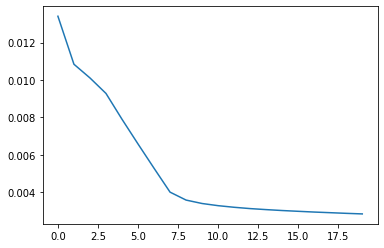

In [7]:
plt.plot(losses)
plt.show()

In [8]:
wrong = 0
classes = dict()
for i in tqdm(range(len(x_test))):
    pred = ml.forward(x_test[i].reshape(1, -1))
    pred = pred.reshape(-1)
    if np.argmax(y_test[i]) != np.argmax(pred):
        wrong += 1
        if np.argmax(y_test[i]) in classes:
            classes[np.argmax(y_test[i])] += 1
        else:
            classes[np.argmax(y_test[i])] = 1
print(f"{round((wrong/len(x_test))*100, 2)}%, ", classes, wrong)

100%|██████████| 25/25 [00:00<00:00, 13875.56it/s]

8.0%,  {1: 1, 2: 1} 2
